In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam, SGD
from tqdm import tqdm
import os

from utils import Encoder, Decoder, additive_white_gaussian_noise_channel, ser_mqam_awgn

In [11]:
CONFIG_TRAIN = {
    "M": 16,  # Number of constellation points
    "flag_train_model": True,  # Flag to control training
    "training_snr": 12,  # Training SNR (dB)
    "best_encoder_path": "./model/ae_siso_awgn_16qam_best_encoder.pth",  # Path to save the best encoder
    "best_decoder_path": "./model/ae_siso_rayleigh_16qam_best_decoder.pth",  # Path to save the best decoder
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [12]:
encoder = Encoder([CONFIG_TRAIN["M"], 10, 10, 2]).to(device)
decoder = Decoder([2, 10, 10, CONFIG_TRAIN["M"]]).to(device)

In [13]:
checkpoint = torch.load(CONFIG_TRAIN["best_encoder_path"], map_location=device)
encoder.load_state_dict(checkpoint)

<All keys matched successfully>

In [14]:
def save_decoder(decoder, loss, optimizer):
    """
    Save the model to a file.
    - decoder: the decoder model
    - loss: the loss history
    - optimizer: the optimizer
    - model_type: "latest"(default) or "best"
    """
    torch.save(
        {
            "Decoder": decoder.state_dict(),
            "loss": loss,
            "optimizer": optimizer.state_dict(),
        },
        CONFIG_TRAIN["best_decoder_path"],
    )


def early_stopping(loss_hist, patience=5):
    """
    Check if the training should be stopped early.
    - loss_hist: list of loss values
    - patience: number of epochs to wait before stopping
    """

    if len(loss_hist) > patience:
        if all(
            x > loss_hist[-1] for x in loss_hist[-(patience + 1) :]
        ):  # if the last patience losses are decreasing
            return True
    return False


def train_decoder(decoder, optimizer, iterations, loss_hist, batch_size):
    criterion = nn.NLLLoss()  # negative log likelihood loss
    best_loss = float("inf")  # Initialize the best loss to infinity
    try:
        for iterator in tqdm(
            range(len(loss_hist), iterations), desc="training process"
        ):
            start_index = int(iterator * batch_size)
            end_index = int((iterator + 1) * batch_size - 1)
            messages_batch = messages[start_index:end_index]
            rx_batch = rx[iterator * batch_size : (iterator + 1) * batch_size - 1]
            y_pred = decoder(rx_batch)
            loss = criterion(y_pred, messages_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())

            if loss.item() < best_loss:
                best_loss = loss.item()
                save_decoder(decoder, loss_hist, optimizer)

            if early_stopping(loss_hist):
                print("Early stopping")
                break
        print("Training complete")

    except KeyboardInterrupt:
        save_decoder(decoder, loss_hist, optimizer)
        print("Training interrupted")

    save_decoder(decoder, loss_hist, optimizer)
    # Plot the loss
    plt.semilogy(loss_hist)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

Training from scratch


training process: 100%|██████████| 1000/1000 [00:02<00:00, 401.24it/s]


Training complete


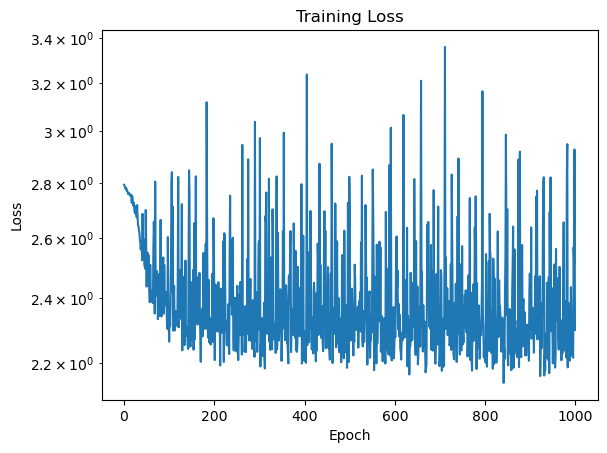

In [15]:
if CONFIG_TRAIN["flag_train_model"]:
    # check if there is a checkpoint to resume training
    if os.path.exists(CONFIG_TRAIN["best_decoder_path"]):
        checkpoint = torch.load(CONFIG_TRAIN["best_decoder_path"], map_location=device)
        # load the model, optimizer a loss history
        decoder.load_state_dict(checkpoint["Decoder"])

    parameters = list(decoder.parameters())
    optimizer = Adam(parameters, lr=0.01)

    if os.path.exists(CONFIG_TRAIN["best_decoder_path"]):
        # optimizer.load_state_dict(checkpoint["optimizer"])
        loss_hist = checkpoint["loss"]
        print(f"Resuming training from iterator {len(loss_hist)}")
    else:
        loss_hist = []
        print("Training from scratch")

    iterations = int(1e3)  # Total number of epochs to train
    batch_size = int(1e4)  # Number of messages to use for training (batch size)
    if iterations > len(loss_hist):
        num_messages = iterations * batch_size - len(loss_hist)
        messages = torch.randint(0, 16, size=(num_messages + 8,), device=device)
        one_hot = F.one_hot(messages, 16).float()
        tx = encoder(one_hot)
        # write tx to a binary file
        tx = tx.detach().numpy()
        with open("./file/tx.dat", "wb") as f:
            f.write(tx.tobytes())
        # run channel.py to generate rx
        os.system("python3 ./gnuradio/fading_awgn_model.py")
        # read rx from a binary file
        with open("./file/rx.dat", "rb") as f:
            rx = np.frombuffer(f.read(), dtype=np.float32)
        rx = torch.from_numpy(rx).to(device)
        rx = rx.view(-1, 2)
        messages = messages[3:-5]
        train_decoder(decoder, optimizer, iterations, loss_hist, batch_size)
    else:
        print("epochs already completed")
else:
    # check if there is a checkpoint to load the model
    if os.path.exists(CONFIG_TRAIN["best_decoder_path"]):
        checkpoint = torch.load(CONFIG_TRAIN["best_decoder_path"], map_location=device)
        decoder.load_state_dict(checkpoint["Decoder"])
        print("Model loaded. Training iterator: ", len(checkpoint["loss"]))
    else:
        print(
            "Model not found, please set flag_train_model to True and train the model"
        )
        exit(1)

In [16]:
num_messages = int(1e4)
messages = torch.randint(0, 16, size=(num_messages + 8,), device=device)
one_hot = F.one_hot(messages, 16).float()
tx = encoder(one_hot)
# write tx to a binary file
tx = tx.detach().numpy()
with open("./file/tx.dat", "wb") as f:
    f.write(tx.tobytes())
# run channel.py to generate rx
os.system("python3 ./gnuradio/fading_awgn_model.py")
# read rx from a binary file
with open("./file/rx.dat", "rb") as f:
    rx = np.frombuffer(f.read(), dtype=np.float32)
rx = torch.from_numpy(rx).to(device)
rx = rx.view(-1, 2)
messages = messages[3:-5]

# load the best decoder
checkpoint = torch.load(CONFIG_TRAIN["best_decoder_path"], map_location=device)
decoder.load_state_dict(checkpoint["Decoder"])

# calculate the SER
y_pred = decoder(rx)
m_hat = torch.argmax(y_pred, -1)
err = torch.sum(torch.not_equal(messages, m_hat)).to("cpu").detach().numpy()
SER = err / len(messages)
print("SER: ", SER)

SER:  0.8341
